In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

%matplotlib inline

## Helper function and constants

In [2]:
LEADS = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
DIAGS = [
    "1st degree AV block (1dAVb)",
    "right bundle branch block (RBBB)",
    "left bundle branch block (LBBB)",
    "sinus bradycardia (SB)",
    "atrial fibrillation (AF)",
    "sinus tachycardia (ST)",
]

## Extract data

In [4]:
import xml.etree.ElementTree as ET


def get_diagnosis(filename: str) -> str:
    root = ET.parse(filename).getroot()
    node = root[6]
    
    diagnosis = 'Diagnosis:\n'
    for i in node:
        if i.tag == "DiagnosisStatement":
            for j in i:
                if j.tag == "StmtText":
                    diagnosis += '\n' + j.text
    return diagnosis

In [5]:
import os
files = []
with open('data/valid.txt') as file_list:
    for line in file_list:
        files.append(line.strip().split('.xml')[0])

In [6]:
ecg = []
diagnosis = []
for file in files:
    data = pd.read_csv('data/csv/' + file.split('/')[-1] + '.csv').drop(columns=["Unnamed: 12", "Unnamed: 13", "V4R"], errors='ignore')
    diag = get_diagnosis(os.path.join('data', file + '.xml'))
    ecg.append(data)
    diagnosis.append(diag)
    # print(file, '\n', diagnosis, '\n', '--------------------------', '\n')
ecg = np.array(ecg)

## Load Model

In [8]:
import tensorflow as tf
from keras.models import load_model
from keras.optimizers import Adam

model = load_model("model/model.hdf5", compile=False)
model.compile(loss="binary_crossentropy", optimizer=Adam())

2023-01-27 14:05:35.749786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 14:05:37.179202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 14:05:37.180268: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Reformat data for model

In [9]:
def resample(ecg, freq):
    X = scipy.signal.resample(ecg, freq * 10, axis=-2)
    if len(X.shape) == 2:
        X = X[None, ...]
        
    length = X.shape[-2]
    if length < 4096:
        pad_left = (4096 - length) // 2
        pad_right = pad_left + (length % 2)
        X = np.pad(X, ((0, 0), (pad_left, pad_right), (0, 0)), "constant")
    else:
        X = X[:, :4096, :]

    X = X / 500
    print(X.shape)
    return X

In [10]:
X = resample(ecg, 400)

(2286, 4096, 12)


In [10]:
Y_pred = model.predict(X)

(2286, 4096, 12)
72/72 [==============================] - 88s 1s/step


In [11]:
filters = [
    {'bloc A-V du premier'},
    {'Bloc de branche droit complet', 'BBD'},
    {'Bloc de branche gauche complet', 'BBG'},
    {'Bradycardie sinusale'},
    {'Fibrillation auriculaire'},
    {'Tachycardie sinusale'},
]
    

In [12]:
def ground_truth(diagnosis):
    Y_ground = []
    for diag in diagnosis:
        y = []
        for group in filters:
            for f in group:
                if f.lower() in diag.lower():
                    y.append(True)
                    break
            else:
                y.append(False)
        Y_ground.append(y)
    return np.array(Y_ground)

In [13]:
Y_ground = ground_truth(diagnosis)

## Precision & Recall

In [15]:
from sklearn.metrics import precision_score, recall_score
def precision(Y_pred, Y_ground, axis):
    return precision_score(Y_ground[:, axis], Y_pred[:, axis])

def recall(Y_pred, Y_ground, axis):
    return recall_score(Y_ground[:, axis], Y_pred[:, axis])

In [28]:
for i, label in enumerate(DIAGS):
    print(label)
    p = precision(Y_pred > 0.5, Y_ground, i)
    r = recall(Y_pred > 0.5, Y_ground, i)
    print(p, '\t', r,'\t', 2 * p * r / (p+r))

1st degree AV block (1dAVb)
0.40384615384615385 	 0.9130434782608695 	 0.5599999999999999
right bundle branch block (RBBB)
0.7310924369747899 	 0.8207547169811321 	 0.7733333333333333
left bundle branch block (LBBB)
0.5092936802973977 	 0.9319727891156463 	 0.658653846153846
sinus bradycardia (SB)
0.9870550161812298 	 0.8425414364640884 	 0.9090909090909092
atrial fibrillation (AF)
0.8181818181818182 	 0.6923076923076923 	 0.7500000000000001
sinus tachycardia (ST)
0.8 	 0.1411764705882353 	 0.24000000000000002


In [176]:
f1, pr, rc = [], [], []
X_stretch = []

for freq in range(320, 501, 20):
    X = resample(ecg, freq)
    Y_pred = model.predict(X)
    
    pr.append([])
    rc.append([])
    f1.append([])
    X_stretch.append(freq / 400)
    
    for i, label in enumerate(DIAGS):
        p = precision(Y_pred > 0.5, Y_ground, i)
        r = recall(Y_pred > 0.5, Y_ground, i)
    
        pr[-1].append(p)
        rc[-1].append(r)
        f1[-1].append(2 * p * r / (p+r))

(2286, 4096, 12)
72/72 [==============================] - 87s 1s/step
(2286, 4096, 12)
72/72 [==============================] - 88s 1s/step
(2286, 4096, 12)
72/72 [==============================] - 87s 1s/step
(2286, 4096, 12)
72/72 [==============================] - 87s 1s/step
(2286, 4096, 12)
72/72 [==============================] - 87s 1s/step
(2286, 4096, 12)
72/72 [==============================] - 87s 1s/step
(2286, 4096, 12)
72/72 [==============================] - 87s 1s/step
(2286, 4096, 12)
72/72 [==============================] - 87s 1s/step
(2286, 4096, 12)
72/72 [==============================] - 87s 1s/step
(2286, 4096, 12)
72/72 [==============================] - 87s 1s/step


In [177]:
stats = np.array([pr, rc, f1])
stats.shape

(3, 10, 6)

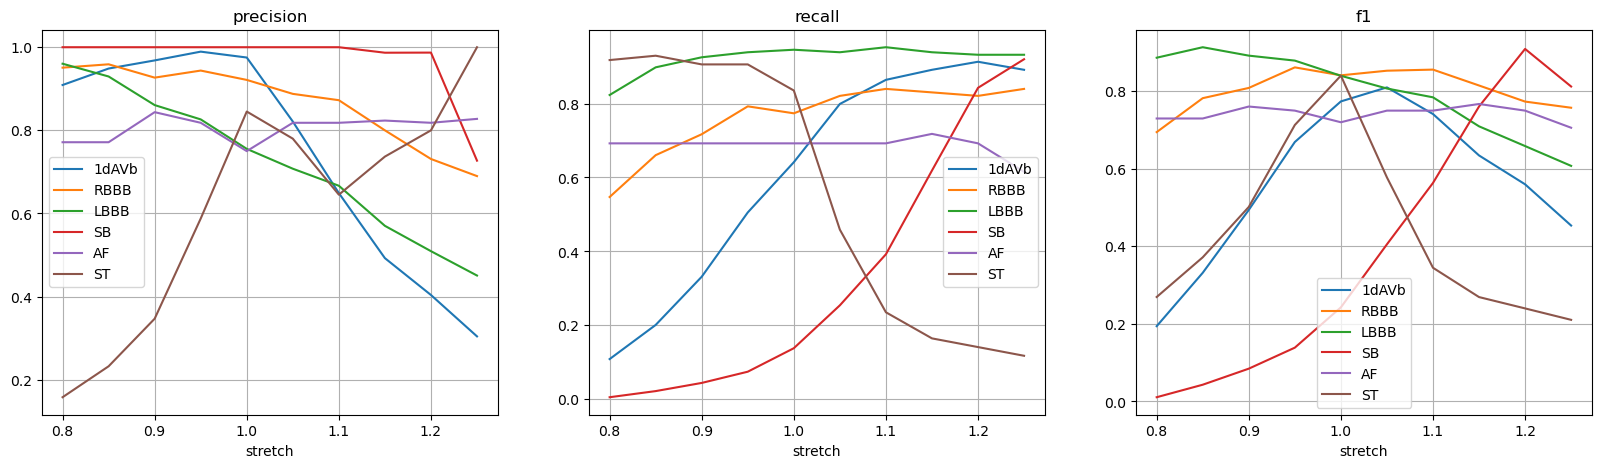

In [182]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
titles = ['precision', 'recall', 'f1']

for i, title in enumerate(titles):
    for j, label in enumerate(DIAGS):
        ax[i].plot(X_stretch, stats[i, :, j], label=label.split('(')[-1].split(')')[0])
    ax[i].set_title(title)
    ax[i].legend()
    ax[i].set_xlabel('stretch')
    ax[i].grid()
plt.savefig('frequency variation.png')
plt.show()

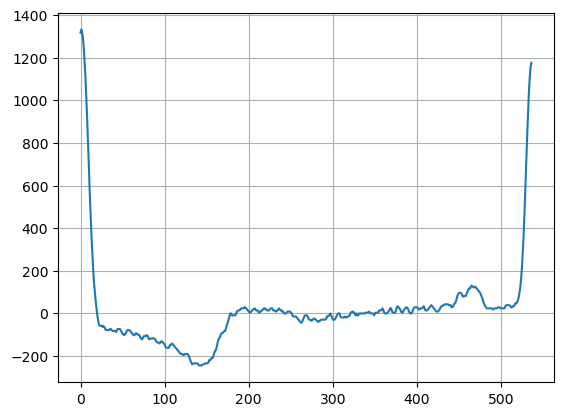

In [140]:
plt.plot(ecg[10, :, 0][300:837])
plt.grid()

In [143]:
(673) / 500

1.346

(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)
(1, 4096, 12)


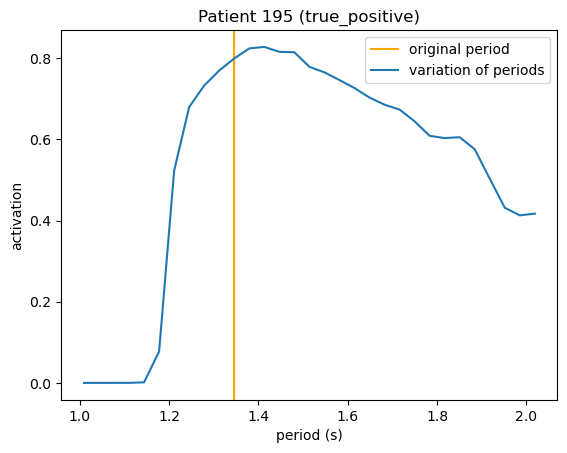

In [187]:
Y_pred = []
X_period = []
for freq in range(300, 601, 10):
    X = resample(ecg[195, ...], freq)
    y = model.predict(X, verbose=False)[0, 3]
    Y_pred.append(y)
    X_period.append(1.346 * freq / 400)
plt.figure()
plt.axvline(x=1.346, label='original period', color='orange')
plt.plot(X_period, Y_pred, label='variation of periods')
plt.legend()
plt.title('Patient 195 (true_positive)')
plt.xlabel('period (s)')
plt.ylabel('activation')
plt.savefig('true_positive.png')
plt.show()

In [146]:
400 * 1.15 / 1.074

428.3054003724394

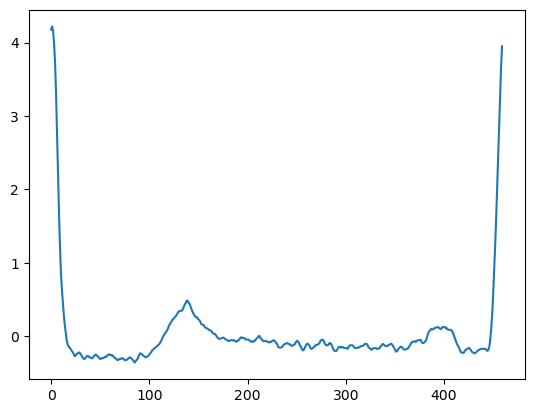

In [155]:
plt.plot(resample(ecg[10, ...], 430)[0, 260:720, 1])

In [156]:
(720-260)/400

1.15

(1, 4096, 12)


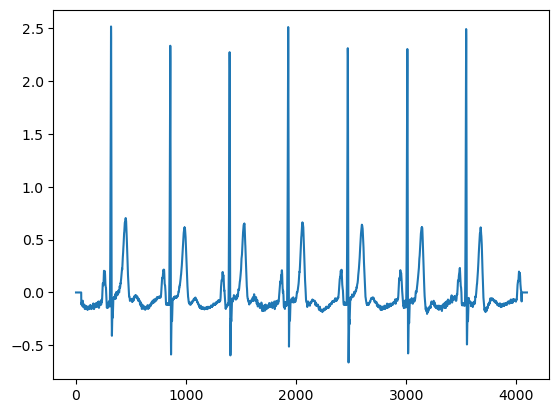

In [121]:
plt.plot(resample(ecg[195, ...], 400)[0, :, 1])

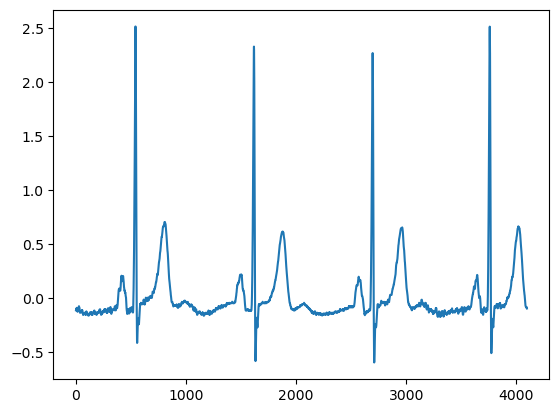

In [160]:
plt.plot(resample(ecg[195, ...], 800)[0, :, 1])

## View predictions

In [18]:
cmp = Y_ground == (Y_pred > 0.5)

In [61]:
diff_sb = (cmp[:, 3] == False) & (Y_ground[:, 3] == True)

In [62]:
diff = diff_sb

In [63]:
i = 2
print(np.arange(len(diagnosis))[diff][i])
print(np.array(diagnosis)[diff][i])
print(Y_pred[diff][i])
print(Y_ground[diff][i])

10
Diagnosis:

Bradycardie sinusale
Possible
Hypertrophie auriculaire gauche (HAG)
ST &
Anomalie de l'onde T, possibilité d'ischémie latérale
ECG anormal
Aucun ECG précédent disponible
[2.7151595e-05 1.2124464e-04 4.0824313e-04 3.5271019e-04 2.4930065e-07
 6.0582899e-08]
[False False False  True False False]


In [44]:
cmp_nsb = np.array(cmp)
cmp_nsb[:, 3] = True
diff_nsb = np.sum(cmp_nsb, axis = 1) != 6
np.sum(diff_nsb)

194

In [46]:
diff_sb.sum()

50

In [47]:
(Y_ground[:, 3] == True).sum()

362

## Shap

In [11]:
import shap

In [12]:
X_img = np.stack((X,) * 3, axis=-1)
masker = shap.maskers.Image("inpaint_telea", X_img[0].shape)

In [13]:
def predict_img(X):
    return model.predict(X[..., 0], verbose=False)

In [14]:
explainer = shap.Explainer(predict_img, masker, output_names=DIAGS)

In [19]:
shap_values = explainer(X_img[195], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip)

Exception: The length of the image to be masked must match the shape given in the ImageMasker contructor: 12 * 3 != 4096 * 12 * 3

In [20]:
shap_values.output_names

['sinus bradycardia (SB)',
 'atrial fibrillation (AF)',
 '1st degree AV block (1dAVb)',
 'right bundle branch block (RBBB)',
 'sinus tachycardia (ST)',
 'left bundle branch block (LBBB)']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


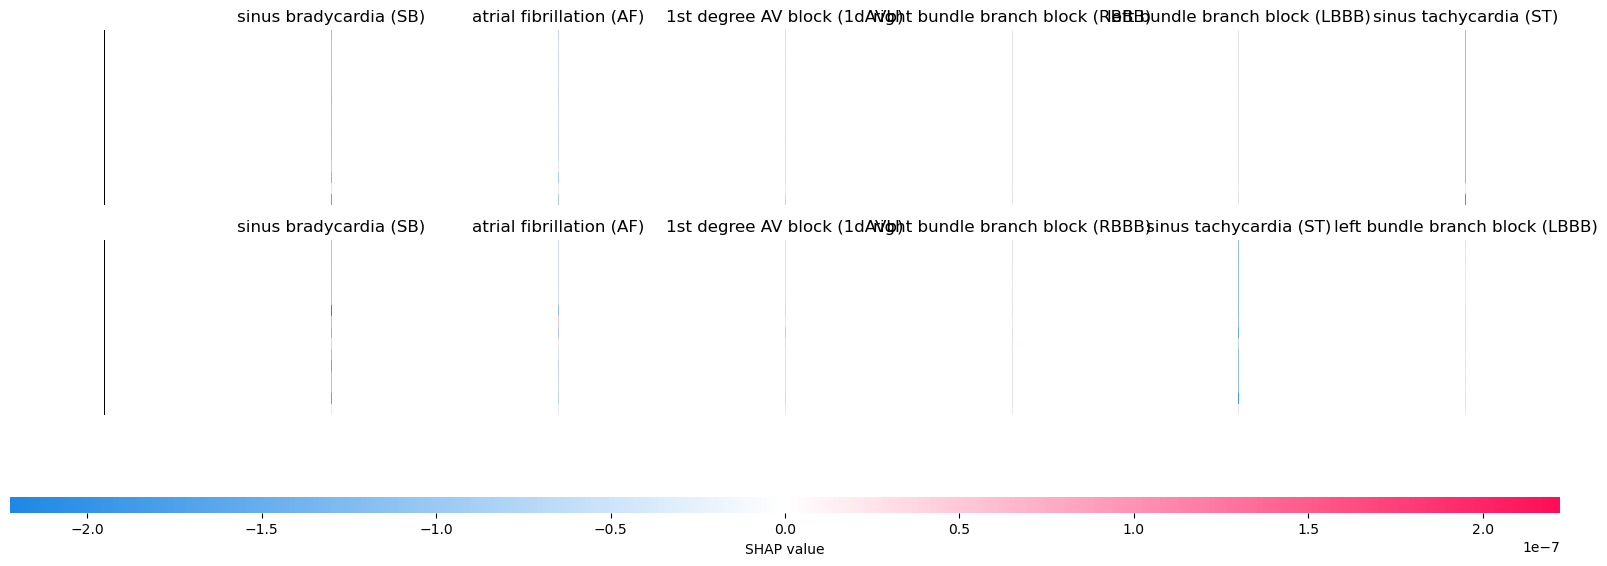

In [29]:
shap.image_plot(shap_values)

In [60]:
shap_values.hierarchical_values.shape

(1, 294911, 6)

In [59]:
shap_values[0][0][0]

.values =
array([[-4.13843939e-09, -1.73993268e-09, -4.27320329e-11,
        -1.02956317e-11,  1.26050867e-10, -7.19796889e-12],
       [-4.13843939e-09, -1.73993268e-09, -4.27320329e-11,
        -1.02956317e-11,  1.26050867e-10, -7.19796889e-12],
       [-4.13843939e-09, -1.73993268e-09, -4.27320329e-11,
        -1.02956317e-11,  1.26050867e-10, -7.19796889e-12]])

.base_values =
array([0.00376934, 0.00154375, 0.00084219, 0.00026849, 0.00463746,
       0.00033455])

.data =
array([0., 0., 0.])

In [61]:
shap_values.output_dims

(4,)

In [48]:
shap_values.data.shape

(1, 4096, 12, 3)

In [46]:
np.array(shap_values).shape

(1, 4096, 4, 0)

In [49]:
from skimage.transform import resize

In [25]:
def resize_img(img):
    print(img.shape)
    tmp = np.repeat(img, 100, axis=1)
    print(tmp.shape)
    return tmp

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4096, 12, 3)
(4096, 1200, 3)


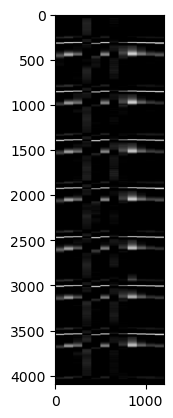

In [45]:
plt.imshow(resize_img(shap_values.data[0]))